# Homework set 3

Please **submit this Jupyter notebook through Canvas** no later than **Mon Nov. 20, 9:00**. **Submit the notebook file with your answers (as .ipynb file) and a pdf printout. The pdf version can be used by the teachers to provide feedback. A pdf version can be made using the save and export option in the Jupyter Lab file menu.**

Homework is in **groups of two**, and you are expected to hand in original work. Work that is copied from another group will not be accepted.

# Exercise 0
Write down the names + student ID of the people in your group.

- Amir Sahrani (12661651)
- Jonas Schäfer (14039982)

Run the following cell to import NumPy and Pyplot.

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# from numba import njit, jit

# Exercise 1

In this exercise you will study the accuracy of several methods for computing the QR decomposition. You are asked to implement these methods yourself. (However, when testing your implementation you may compare with an external implementation.)


## (a) 
Implement the classical and modified Gram-Schmidt procedures for computing the QR decomposition.

Include a short documentation using triple quotes: describe at least the input and the output, and whether the code modifies the input matrix.

### Gramm-schmidt
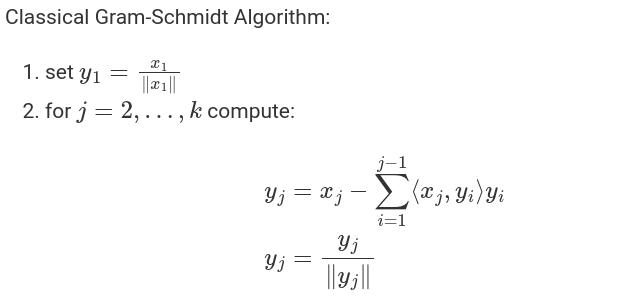

### Modified Gramm-schmidt
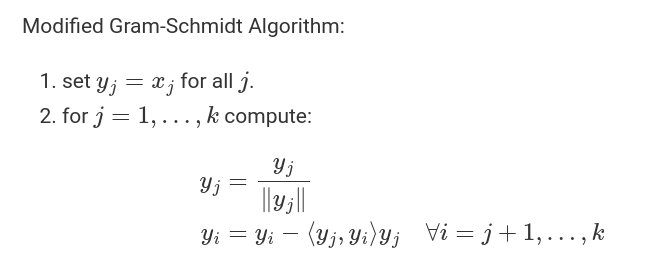

In [285]:
def classical_gs_qr(A):
    """
    Classical Gram-Schmidt algorithm for QR decomposition, not modifying the input matrix
    :param A: an m x n matrix with linearly independent columns
    :return: (Q, R) where Q is an m x n matrix with orthonormal columns and R is an upper triangular matrix such that Q@R ≈ A
    """
    A_copy = A.copy()
    m, n = A.shape
    Q = np.zeros((m,n))
    R = np.zeros((m,n))

    for j in range(n):
        y = A[:,j]
        for i in range(j):
            coefficient = np.dot(Q[:, i], y)
            y = y - coefficient * Q[:, i]
            R[i,j] = coefficient
        norm = np.linalg.norm(y)
        if norm == 0:
            raise ValueError("The columns of A are linearly dependent.")
        R[j,j] = norm
        Q[:,j] = y / norm
    assert (A==A_copy).all(), "The input matrix was modified."
    return Q,R        

    # for j in range(n):
    #     R[j,j] = np.linalg.norm(V[:,j])
    #     Q[:,j] = V[:,j] / R[j,j]
    #     for k in range(j):
    #         R[k, j] = Q[:, k].T @ V[:, j] 
    #         V[:, j] -= R[k, j] * Q[:, k]
    #     R[j,j] = np.linalg.norm(V[:,j])
    #     if R[j,j] == 0:
    #         raise ValueError("The columns of A are linearly dependent.")

def modified_gs_qr(A):
    """
    Modified Gram-Schmidt algorithm, not modifying the input matrix
    :param A: an m x n matrix with linearly independent columns
    :return: (Q, R) where Q is an m x n matrix with orthonormal columns and R is an m x n upper triangular matrix such that Q@R ≈ A
    """
    A_copy = A.copy()
    m, n = A.shape
    Q = np.zeros((m, n))
    R = np.zeros((m, n))
    V =  A.copy()

    for j in range(n):
        R[j,j] = np.linalg.norm(V[:,j])
        Q[:,j] = V[:,j] / R[j,j]
        if R[j,j] == 0:
            raise ValueError("The columns of A are linearly dependent.")

        for k in range(j+1,n):
            R[j, k] = Q[:, j].T @ V[:, k] 
            V[:, k] -= R[j, k] * Q[:, j]

    assert (A==A_copy).all(), "The input matrix was modified."
    return Q,R

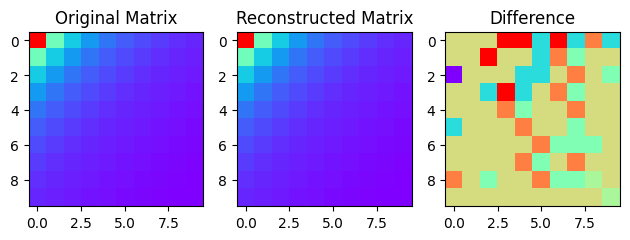

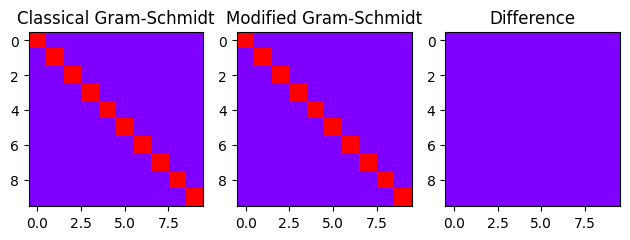

In [286]:
H = HilbertMatrix(10)
Q,R = classical_gs_qr(H)
mQ, mR = modified_gs_qr(H)
recon = mQ @ mR    

cmap = 'rainbow'

plt.subplot(1, 3, 1)
plt.imshow(H, cmap=cmap)
plt.title("Original Matrix")

plt.subplot(1, 3, 2)
plt.imshow(recon, cmap=cmap)
plt.title("Reconstructed Matrix")

plt.subplot(1, 3, 3)
plt.imshow(H- recon, cmap=cmap)
plt.title("Difference")
plt.tight_layout()
plt.show()

plt.subplot(1, 3, 1)
plt.imshow(Q @ Q.T, cmap=cmap)
plt.title("Classical Gram-Schmidt")
plt.subplot(1, 3, 2)
plt.imshow(mQ @ mQ.T, cmap=cmap)
plt.title("Modified Gram-Schmidt")
plt.subplot(1, 3, 3)
plt.imshow(Q @ Q.T - mQ @ mQ.T, cmap=cmap)
plt.title("Difference")
plt.tight_layout()
plt.show()

## (b) (a+b 3.5 pts)
Let $H$ be a Hilbert matrix of size $n$ (see Computer Problem 2.6). Study the quality of the QR decompositions obtained using the two methods of part (a), specifically the loss of orthogonality. In order to do so, plot the quantity $\| I - Q^T Q \|$ as a function of $n$ on a log scale. Vary $n$ from $2$ to $12$.



In [287]:
def HilbertMatrix(n):
    i,j = np.indices((n,n))
    return 1/(i+j+1)

def test_QR(A, Q, R, rtol=1e-4):
    assert np.count_nonzero(np.isclose(A, Q@R, rtol=rtol)) == A.shape[0] * A.shape[1], f"QR decomposition is not accurate within error tolerance {rtol} specified."

def test_orthogonal(Q, rtol=1e-4):
    assert np.count_nonzero(np.isclose(Q.T@ Q, np.eye(*Q.shape), rtol=rtol)) == Q.shape[0] * Q.shape[1], f"Q is not orthogonal."

def test_qr_decomp_func(f, n=6, rtol=1e-4):
    hilbert = HilbertMatrix(n)
    Q, R = f(hilbert)
    test_QR(hilbert, Q, R, rtol=rtol)
    test_orthogonal(Q, rtol=rtol)
    print(f'QR decomposition {f.__name__} is accurate to error tolerance of {rtol}.')

def loss_of_orthogonality(QRs):
    return [np.linalg.norm(np.eye(*Q.shape) - Q.T@Q) for Q, _ in QRs]

def compare_loss_qr_decomp_methods(fs, n_space=(2, 13)):
    QR_pairs = [[] for _ in range(len(fs))]
    n_low, n_high = n_space
    n_space = np.arange(n_low, n_high, 1)
    for n in n_space:
        hilbert = HilbertMatrix(n)
        for i, f in enumerate(fs):
            Q, R = f(hilbert)
            QR_pairs[i].append((Q, R))
    
    loss_of_orthogonalities = [loss_of_orthogonality(QRs) for QRs in QR_pairs]
    return n_space, loss_of_orthogonalities

QR decomposition classical_gs_qr is accurate to error tolerance of 0.0001.
QR decomposition modified_gs_qr is accurate to error tolerance of 0.0001.


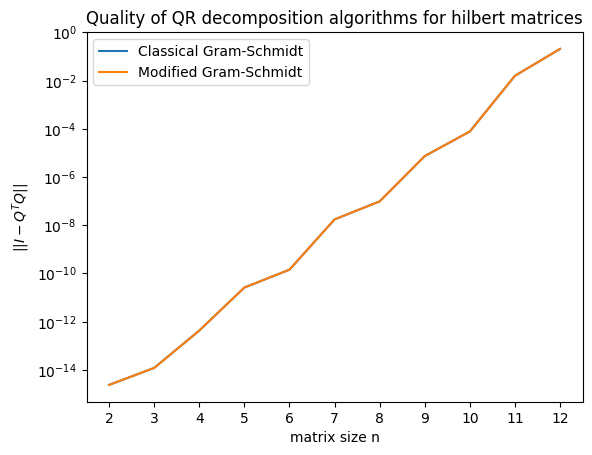

In [288]:
test_qr_decomp_func(classical_gs_qr)
test_qr_decomp_func(modified_gs_qr) # Currently failing due to lack of implementation of modified_gram_schmidt

n_space, losses = compare_loss_qr_decomp_methods(fs=(classical_gs_qr, modified_gs_qr))
loss_classic, loss_modified = losses[0], losses[1]

plt.plot(n_space, loss_classic, label='Classical Gram-Schmidt')
plt.plot(n_space, loss_modified, label='Modified Gram-Schmidt')
plt.xlabel('matrix size n')
plt.xticks(n_space)
plt.ylabel('$||I - Q^TQ||$')
plt.yscale('log')
plt.title('Quality of QR decomposition algorithms for hilbert matrices')
plt.legend()
plt.show()

## (c) (1.5 pts)
Try applying the classical procedure twice. Plot again the loss of orthogonality when computing the QR decomposition of the Hilbert matrix of size $n$ as in (b).


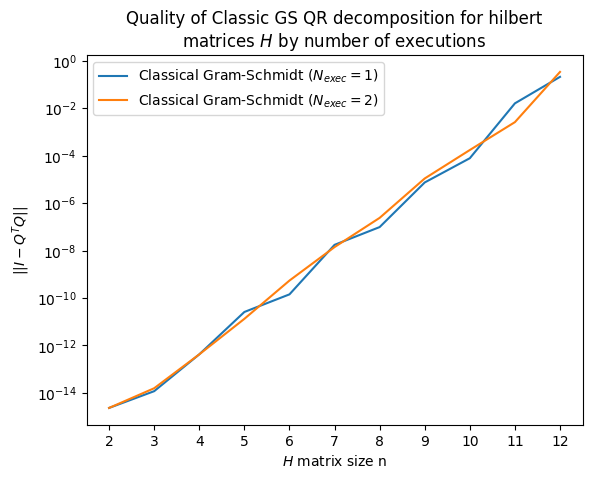

In [289]:
def classical_gram_schmidt_twice(A):
    Q, R = classical_gs_qr(A)
    Q, R = classical_gs_qr(Q@R)
    return Q, R

n_space, losses = compare_loss_qr_decomp_methods(n_space=(2, 13), fs = (classical_gs_qr, classical_gram_schmidt_twice))
loss_classic, loss_classic_twice = losses[0], losses[1]

plt.plot(n_space, loss_classic, label='Classical Gram-Schmidt ($N_{{exec}}=1$)')
plt.plot(n_space, loss_classic_twice, label='Classical Gram-Schmidt ($N_{{exec}}=2$)')
plt.xlabel('$H$ matrix size n')
plt.xticks(n_space)
plt.ylabel('$||I - Q^TQ||$')
plt.yscale('log')
plt.title('Quality of Classic GS QR decomposition for hilbert\nmatrices $H$ by number of executions')
plt.legend()
plt.show()

## (d) (2 pts)
Implement the Householder method for computing the QR decomposition. Remember to include a short documentation.

In [246]:
def householder_qr(A):
    """
    Householder QR decomposition, not modifying the input matrix
    :param A: an m x n matrix with linearly independent columns
    :return: (Q, R) where Q is an m x n matrix with orthonormal columns and R is an m x n upper triangular matrix such that Q@R ≈ A
    """
    A_copy = A.copy()
    m, n = A.shape
    Q = np.eye(m)
    R = A.copy()

    for j in range(min(m-1, n)):
        x = R[j:, j]
        v = x.copy()
        v[0] = v[0] + np.sign(x[0]) * np.linalg.norm(x)
        v = v / np.linalg.norm(v)
        total_1 = 2 * np.outer(v, np.dot(v, R[j:, j:]))
        total_2 = 2 * np.outer(Q[:, j:].dot(v), v)
        R[j:, j:] = R[j:, j:] - total_1
        Q[:, j:] = Q[:, j:] - total_2
    assert (A==A_copy).all(), "The input matrix was modified."
    return Q, R

test_qr_decomp_func(householder_qr)

QR decomposition householder_qr is accurate to error tolerance of 0.0001.


## (e) (2 pts)
Perform the analysis of (b) for the Householder method. Discuss the differences between all the methods you have tested so far. Look online and/or in books for information about the accuracy of the different methods and include this in your explanations (with reference).


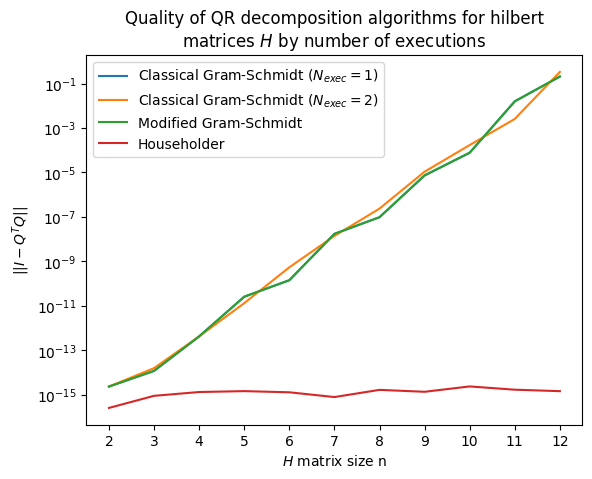

In [290]:
n_space, losses = compare_loss_qr_decomp_methods(n_space=(2, 13), fs = (classical_gs_qr, classical_gram_schmidt_twice, modified_gs_qr, householder_qr))
loss_classic, loss_classic_twice, loss_modified, loss_householder = losses[0], losses[1], losses[2], losses[3]

plt.plot(n_space, loss_classic, label='Classical Gram-Schmidt ($N_{{exec}}=1$)')
plt.plot(n_space, loss_classic_twice, label='Classical Gram-Schmidt ($N_{{exec}}=2$)')
plt.plot(n_space, loss_modified, label='Modified Gram-Schmidt')
plt.plot(n_space, loss_householder, label='Householder')
plt.xlabel('$H$ matrix size n')
plt.xticks(n_space)
plt.ylabel('$||I - Q^TQ||$')
plt.yscale('log')
plt.title('Quality of QR decomposition algorithms for hilbert\nmatrices $H$ by number of executions')
plt.legend()
plt.show()

A big reason as to why the regular Gram-Schmidt method for decomposition is unstable is because the calculations from the previous column in Q are used for the computation in the subsequene columns this means any numerical errors and rounding errors get propagated through out the calculation. The modified version of the GS method do not depend on the previous computations and therefore does not propagate these errors.

Although MGS prevents the errors that occurred during the computation of one of the vectors form propagating to the next one. It cannot deal with error that occur within the computation of one vector. Householder reflections can sovle this issue, instead of calculating the vector by subtracting the projections, it calculates the distance between the reflections and subtracts those once, thereby reducing oportunities for numberical error.